In [1]:
"""
Dependency
----------
1. This notebook assumes that Anayzer has been executed and it byproducts 
   (e.g. performance dataframe) have been generated.

2. This module is essentially a "ClassifierArray-Part2"
"""
import pandas as pd 
from pandas import DataFrame, Series
import os
import numpy as np
from decimal import Decimal

import warnings
warnings.filterwarnings('ignore')  # action='once'

np.set_printoptions(precision=3)

%matplotlib inline

In [2]:
from analyzer import load_performance, label_by_performance

cohort = 'hepatitis-c'
df_perf = load_performance(input_dir='result', cohort=cohort)
n_init = df_perf.shape[0]
print("> col(pd_perf): {}\n".format(df_perf.columns))

dfp = df_perf.loc[df_perf['mean'] > 0].sort_values(by=['mean', ])
for code, score in zip(dfp['code'], dfp['mean']):
    print(f"[{code}] -> {score}")

> dim(performance matrix): (733, 4)
> col(pd_perf): Index(['code', 'mean', 'std', 'n_pos'], dtype='object')

[33498] -> 0.4049533799533799
[150136] -> 0.41125814200717736
[661496] -> 0.41306471306471293
[60822] -> 0.4832203885409654
[54031] -> 0.5293650793650794
[18341] -> 0.550254110612855
[7377] -> 0.6002158380676135
[82206] -> 0.6010306365624156
[462168] -> 0.6866666666666666
[81166] -> 0.7190476190476189
[80614] -> 0.7333856345885634
[80143] -> 0.7334402566158781
[285452] -> 0.7335298935298935
[823781] -> 0.7371428571428571
[31674] -> 0.7381526104417672
[327692] -> 0.7389671361502347
[51573] -> 0.7504761904761905
[62760] -> 0.7777777777777778
[75007] -> 0.7805454813504349
[505586] -> 0.7866666666666666
[138016] -> 0.7980952380952379
[322156] -> 0.7999999999999999
[24687] -> 0.8000151917964299
[385187] -> 0.8003110419906687
[487678] -> 0.8009237875288683
[110510] -> 0.8014598540145986
[51599] -> 0.8019323671497585
[56457] -> 0.8037037037037038
[223222] -> 0.8047619047619048
[31427] 

### Identify target LOINC codes

In [3]:
# some statistics
th_low, th_high = 0.50, 0.90
n_codes = df_perf.shape[0]
assert n_codes == n_init

################################################
categories = ['easy', 'hard', 'low']
ccmap = label_by_performance(cohort=cohort, categories=categories)
N = size_hashtable(ccmap)
N_easy = len(ccmap['easy'])
N_hard = len(ccmap['hard'])
N_low = len(ccmap['low'])

target_codes = codes = df_perf['code'].values  # codes associated with a given cohort (e.g. hepatitis c)
codes_low_sz = ccmap['low']
codes_scored = np.hstack([ccmap['easy'], ccmap['hard']]) # <<<<< 
codes_high_score = ccmap['easy']  # df_perf.loc[df_perf['mean'] >= th_high]['code'].values
codes_low_score = ccmap['hard'] # df_perf.loc[(df_perf['mean'] < th_high) & (df_perf['mean'] >= 0)]['code'].values
################################################
assert n_codes == len(codes_low_sz) + len(codes_scored)

r_low_sz = round( len(codes_low_sz)/(n_codes+0.0) * 100, 3)
r_scored = round( len(codes_scored)/(n_codes+0.0) * 100, 3)
r_high_score = round( len(codes_high_score)/(n_codes+0.0) * 100, 3)

print("1. Total number of codes: {} | n(low_sample): {}({}%), n(scored):{}({}%), n(high scored):{}({}%)".format(n_codes, 
   len(codes_low_sz), r_low_sz, len(codes_scored), r_scored, len(codes_high_score), r_high_score))
print("2. Pecentage scored codes: {}%".format(r_scored))
print("3. Percentage \"good\" codes: {}%".format(r_high_score))

# Effective performance dataframe, ruling out those codes without scores (due to low sample sizes)
df_eff = df_perf.loc[df_perf['mean'] >= 0.0]

# top N and low N
n_offset = 25
df_topn = df_eff.sort_values(['mean', ], ascending=False).head(n_offset)
df_botn = df_eff.sort_values(['mean', ], ascending=True).head(n_offset)

################################################
# key vars: 
#   target_codes, codes_scored, codes_low_sz, codes_high_score, codes_low_score


1. Total number of codes: 733 | n(low_sample): 292(39.836%), n(scored):441(60.164%), n(high scored):371(50.614%)
2. Pecentage scored codes: 60.164%
3. Percentage "good" codes: 50.614%


## Inspect Loinc Table

In [4]:
from analyzer import sample_loinc_table

cols_inspect = []
adict = sample_loinc_table(codes=target_codes, cols=cols_inspect, n_samples=10, verbose=1)

> dim(table): (92369, 46)
[1] loinc: 264531:
  - LOINC_NUM: 264531
  - COMPONENT: Erythrocytes
  - PROPERTY: NCnc
  - TIME_ASPCT: Pt
  - SYSTEM: Bld
  - SCALE_TYP: Qn
  - METHOD_TYP: nan
  - CLASS: HEM/BC
  - VersionLastChanged: 2.66
  - CHNG_TYPE: MIN
  - DefinitionDescription: nan
  - STATUS: ACTIVE
  - CONSUMER_NAME: nan
  - CLASSTYPE: 1
  - FORMULA: nan
  - SPECIES: nan
  - EXMPL_ANSWERS: nan
  - SURVEY_QUEST_TEXT: nan
  - SURVEY_QUEST_SRC: nan
  - UNITSREQUIRED: Y
  - SUBMITTED_UNITS: nan
  - RELATEDNAMES2: #; ABS; absolute; absolutes; Blood; Cnt; Count; Count/volume; CT; Discocytes; Erthrocyte; Erythrocyte; HEMATOLOGY/CELL COUNTS; Number concentration; Number Concentration (count/vol); Point in time; QNT; Quan; Quant; Quantitative; Random; RBC; RBCS; Red blood cell; Red blood cells; Red blood corpuscle; Red blood corpusles; Red cell; Red cells; WB; Whole blood
  - SHORTNAME: RBC # Bld
  - ORDER_OBS: Observation
  - CDISC_COMMON_TESTS: Y
  - HL7_FIELD_SUBFIELD_ID: nan
  - EXTERNAL

### Load LOINC Table(s)

In [5]:
from loinc import load_loinc_table, sample_loinc_table
from transformer import dehyphenate

"""
Key features  
   LONG_COMMON_NAME
   SHORTNAME
    
   RELATEDNAMES2
   STATUS_TEXT

"""

def label_as(lv, i, s='easy', codebook={'easy': 1, 'hard': 0}): 
    lv[i] = codebook[s]
    return
        
labels = ['easy', 'hard']
col_code = 'LOINC_NUM'
cols_target = "COMPONENT, PROPERTY, TIME_ASPCT, SYSTEM, METHOD_TYP, SCALE_TYP"  # CLASS
cols_6p = ["COMPONENT","PROPERTY","TIME_ASPCT","SYSTEM","SCALE_TYP","METHOD_TYP"]   # CLASS
codebook = {'easy': 1, 'hard': 0}

# load LOINC table
df_loinc = load_loinc_table()
print("> col(Loinc Table):\n{}\n".format(list(df_loinc.columns.values)))

fset = cols_6p # cols_6p = [col.strip() for col in cols_target.split(',')]
# assert sum(1 for col in cols_6p if not col in df_loinc.columns) == 0  # ... ok

dehyphenate(df_loinc, col=col_code)  # inplace
# assert sum(1 for code in df_loinc[col_code] if code.find('-') >= 0) == 0  # ... ok

codes_src = set(df_loinc[col_code].values)
n_codes_missed = 0
dfx = []

levels = [] # np.zeros(len(target_codes), dtype=int) # .astype(int)
codes_eff = [] 
codes_missed = []
for i, code in enumerate(target_codes): 
    if code in codes_src: 
        codes_eff.append(code) # codes with the desired feature represenation (e.g. 6 parts)
        
        row = df_loinc.loc[df_loinc[col_code] == code][cols_6p]
        assert row.shape[0] == 1, "multiple rows? {}".format(row)
        dfx.append(row) # note: 'df_loinc[col_code] == code' returns a sliced dataframe
        
        # labeling
        if code in codes_high_score: 
            # label_as(levels, i, 'easy')
            levels.append('easy') # codebook['easy']
        else: 
            levels.append('hard') # codebook['hard']
            
    else: 
        n_codes_missed += 1
        codes_missed.append(code)
        
df = pd.concat(dfx, ignore_index=True)
df['label'] = levels   # <<< label
df['y'] = [codebook[level] for level in levels]
df['code'] = codes_eff

msg = "> dim(df: six_parts): {}\n".format(df.shape)
msg += f"> # codes not found in loinc table: {n_codes_missed}\n"

print(msg)
print(df.sample(10))

################################################################################


> dim(table): (92369, 46)
> col(Loinc Table):
['LOINC_NUM', 'COMPONENT', 'PROPERTY', 'TIME_ASPCT', 'SYSTEM', 'SCALE_TYP', 'METHOD_TYP', 'CLASS', 'VersionLastChanged', 'CHNG_TYPE', 'DefinitionDescription', 'STATUS', 'CONSUMER_NAME', 'CLASSTYPE', 'FORMULA', 'SPECIES', 'EXMPL_ANSWERS', 'SURVEY_QUEST_TEXT', 'SURVEY_QUEST_SRC', 'UNITSREQUIRED', 'SUBMITTED_UNITS', 'RELATEDNAMES2', 'SHORTNAME', 'ORDER_OBS', 'CDISC_COMMON_TESTS', 'HL7_FIELD_SUBFIELD_ID', 'EXTERNAL_COPYRIGHT_NOTICE', 'EXAMPLE_UNITS', 'LONG_COMMON_NAME', 'UnitsAndRange', 'EXAMPLE_UCUM_UNITS', 'EXAMPLE_SI_UCUM_UNITS', 'STATUS_REASON', 'STATUS_TEXT', 'CHANGE_REASON_PUBLIC', 'COMMON_TEST_RANK', 'COMMON_ORDER_RANK', 'COMMON_SI_TEST_RANK', 'HL7_ATTACHMENT_STRUCTURE', 'EXTERNAL_COPYRIGHT_LINK', 'PanelType', 'AskAtOrderEntry', 'AssociatedObservations', 'VersionFirstReleased', 'ValidHL7AttachmentRequest', 'DisplayName']

> dim(df: six_parts): (722, 9)
> # codes not found in loinc table: 11

                                          COMP

### Target LOINC Codes Summary

In [6]:
print("> 1. Codes not found in LOINC table (n={})".format(len(codes_missed)))
for code in codes_missed: 
    print("  + {}".format(code))
print('-' * 50 + '\n')

# find codes not found in the standard LOINC table via MapTo.csv
df_mapto = load_loinc_table(input_dir='LoincTable', input_file='MapTo.csv', sep=',') 
# ... cols: "LOINC" (Obsolete LNC code),"MAP_TO" (current code),"COMMENT"

dehyphenate(df_mapto, col=['LOINC', 'MAP_TO'])  # inplace
codes_old = df_mapto['LOINC'].values
codes_new = df_mapto['MAP_TO'].values

nM = nO = nN =0
for code in codes_missed: 
    if code in codes_old: 
        print("!!! {} found in obsolete set".format(code))
        nO += 1
    if code in codes_new: 
        print("!!! {} found in mapped to set (current)".format(code))
        nN += 1
nM = nO + nN
print(f"!!! {nM} missing cases found in MapTo ... #")

################################################################################

text_cols = ['LONG_COMMON_NAME', 'SHORTNAME', 'RELATEDNAMES2', 'STATUS_TEXT']
property_cols = cols_6p + ['CLASS'] # ["COMPONENT","PROPERTY","TIME_ASPCT","SYSTEM","SCALE_TYP","METHOD_TYP"] 
select_cols = [col_code, ] + text_cols + property_cols

codes_easy = df.loc[df['label'] == 'easy'][ 'code' ].values
codes_hard = df.loc[df['label'] == 'hard'][ 'code' ].values

# print("> col(df_loincs): {}".format(df_loinc.columns.values))
df_codes_easy = df_loinc.loc[df_loinc[col_code].isin(codes_easy)][select_cols]
df_codes_hard = df_loinc.loc[df_loinc[col_code].isin(codes_hard)][select_cols]

print("> 2.1 Easy cases (n={}) ".format(len(codes_easy)))
for r, row in df_codes_easy.iterrows():
    code = row[col_code]
    p6 = [row['COMPONENT'], row['PROPERTY'], row['TIME_ASPCT'], row['SYSTEM'], row['METHOD_TYP'], row['SCALE_TYP'], row['CLASS']]
    six_parts = ': '.join(str(e) for e in p6)
    print("[{}] {} (6p: {}) =>\n ... {}\n".format(r+1, code, six_parts, row['LONG_COMMON_NAME']))
    
print("> 2.2 Hard cases (n={}) ".format(len(codes_hard)))
for r, row in df_codes_hard.iterrows():
    code = row[col_code]
    p6 = [row['COMPONENT'], row['PROPERTY'], row['TIME_ASPCT'], row['SYSTEM'], row['METHOD_TYP'], row['SCALE_TYP'], row['CLASS']]
    six_parts = ': '.join(str(e) for e in p6)
    print("[{}] {} (6p: {}) =>\n ... {}\n".format(r+1, code, six_parts, row['LONG_COMMON_NAME']))

# perhaps the missed codes are older codes, which have been mapped to new codes (MapTo.csv)

> 1. Codes not found in LOINC table (n=11)
  + 17435
  + 80100
  + 882934
  + 005025
  + 99006
  + 550513
  + 75007
  + unknown
  + 84999
  + 30741
  + 5056360
--------------------------------------------------

> dim(table): (3544, 3)
!!! 0 missing cases found in MapTo ... #
> 2.1 Easy cases (n=368) 
[519] 104661 (6p: Anion gap 3: SCnc: Pt: Ser/Plas: nan: Qn: CHEM) =>
 ... Anion gap 3 in Serum or Plasma

[557] 105015 (6p: Lutropin: ACnc: Pt: Ser/Plas: nan: Qn: CHEM) =>
 ... Lutropin [Units/volume] in Serum or Plasma

[779] 107011 (6p: Ova & parasites identified: Prid: Pt: Stool: Concentration: Nom: MICRO) =>
 ... Ova and parasites identified in Stool by Concentration

[927] 108340 (6p: Globulin: MCnc: Pt: Ser: Calculated: Qn: CHEM) =>
 ... Globulin [Mass/volume] in Serum by calculation

[985] 108860 (6p: Prostate specific Ag.free: MCnc: Pt: Ser/Plas: nan: Qn: CHEM) =>
 ... Prostate Specific Ag Free [Mass/volume] in Serum or Plasma

[1002] 109009 (6p: Hepatitis B virus surface Ab: PrTh


[24349] 322867 (6p: Hepatitis C virus genotype: Prid: Pt: Ser/Plas: Probe.amp.tar: Nom: MICRO) =>
 ... Hepatitis C virus genotype [Identifier] in Serum or Plasma by NAA with probe detection

[24390] 323238 (6p: Ketones: SCnc: Pt: XXX: nan: Qn: CHEM) =>
 ... Ketones [Moles/volume] in Unspecified specimen

[24724] 326231 (6p: Platelet mean volume: EntVol: Pt: Bld: Automated count: Qn: HEM/BC) =>
 ... Platelet mean volume [Entitic volume] in Blood by Automated count

[24725] 326249 (6p: Race: Type: Pt: ^Patient: nan: Nom: CLIN) =>
 ... Race

[24844] 327312 (6p: Beta 2 globulin: MCnc: Pt: Ser/Plas: Electrophoresis: Qn: CHEM) =>
 ... Beta 2 globulin [Mass/volume] in Serum or Plasma by Electrophoresis

[24894] 327767 (6p: Erythrocytes: PrThr: Pt: Urine sed: Microscopy.light: Ord: UA) =>
 ... Erythrocytes [Presence] in Urine sediment by Light microscopy

[25026] 32896 (6p: Prothrombin.activity actual/Normal: RelTime: Pt: PPP: Coag: Qn: COAG) =>
 ... Prothrombin activity actual/normal in Plat

### Variable Properties

In [7]:
from analyzer import det_cardinality, det_cardinality2
from transformer import encode_vars

# fill in missing values (also see default_values)
token_missing = "-" 

# missing_default = {"PROPERTY": token_missing,  # nc = 49, 
#                    "TIME_ASPCT": '*',                    
# }

df.fillna(value=token_missing, inplace=True)

print("> Before variable encoding: dim(df): {}\n> Header: {}".format(df.shape, df.columns[:100]))
print(df.sample(10)); print('-' * 50 + '\n')

# determine cardinality 
# card = det_cardinality(df, th_card=10, cols=fset, verbose=1)
# ... if >= th_card, consider as high-cardinality categorical vas
# ... card: var -> {True, False}, True if high card

card = det_cardinality2(df, th_card=10, cols=fset, verbose=1)
high_card_cols = card['high_card']

# print(card) # car

> Before variable encoding: dim(df): (722, 9)
> Header: Index(['COMPONENT', 'PROPERTY', 'TIME_ASPCT', 'SYSTEM', 'SCALE_TYP',
       'METHOD_TYP', 'label', 'y', 'code'],
      dtype='object')
                            COMPONENT PROPERTY TIME_ASPCT     SYSTEM  \
324         Epithelial cells.squamous    Naric         Pt  Urine sed   
84                       Norclozapine     MCnc         Pt   Ser/Plas   
565                        Leukocytes     NCnc         Pt        Bld   
380             Hepatitis C virus RNA     ACnc         Pt   Ser/Plas   
503  Necroinflammatory activity grade     Find         Pt   Ser/Plas   
599        Neutrophils/100 leukocytes      NFr         Pt        Bld   
159                         Methadone    PrThr         Pt   Ser/Plas   
524          Alanine aminotransferase     CCnc         Pt   Ser/Plas   
161    Tissue transglutaminase Ab.IgG     ACnc         Pt        Ser   
120                          HIV 2 Ab    PrThr         Pt   Ser/Plas   

    SCALE_TYP   

### Data Curation (missing value + variable encoding)

In [8]:
from transformer import categorify 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

cat_cols = cols_6p
cont_cols = []
# df, encoder = encode_vars(df, high_card_cols=high_card_cols, fset=cat_cols)

encoding_mode = 1

if encoding_mode in (1, 'binary'): 
    # use binary ecoder for all vars
    df, encoder = encode_vars(df, high_card_cols=cat_cols, fset=cat_cols) 
elif encoding_mode in (2, ):
    df = categorify(df, cat_cols=cat_cols)
    
print("> After variable encoding: dim(df): {}\n> Header: {}".format(df.shape, df.columns[:100]))
print(df.sample(10))


(encoder_vars) low card vars (n=[]):
0
 ... high card vars (n=['COMPONENT', 'PROPERTY', 'TIME_ASPCT', 'SYSTEM', 'SCALE_TYP', 'METHOD_TYP']):
6

... transforming var: COMPONENT ...
... transforming var: PROPERTY ...
... transforming var: TIME_ASPCT ...
... transforming var: SYSTEM ...
... transforming var: SCALE_TYP ...
... transforming var: METHOD_TYP ...
> After variable encoding: dim(df): (722, 40)
> Header: Index(['COMPONENT_0', 'COMPONENT_1', 'COMPONENT_2', 'COMPONENT_3',
       'COMPONENT_4', 'COMPONENT_5', 'COMPONENT_6', 'COMPONENT_7',
       'COMPONENT_8', 'COMPONENT_9', 'PROPERTY_0', 'PROPERTY_1', 'PROPERTY_2',
       'PROPERTY_3', 'PROPERTY_4', 'PROPERTY_5', 'PROPERTY_6', 'TIME_ASPCT_0',
       'TIME_ASPCT_1', 'TIME_ASPCT_2', 'SYSTEM_0', 'SYSTEM_1', 'SYSTEM_2',
       'SYSTEM_3', 'SYSTEM_4', 'SYSTEM_5', 'SCALE_TYP_0', 'SCALE_TYP_1',
       'SCALE_TYP_2', 'SCALE_TYP_3', 'METHOD_TYP_0', 'METHOD_TYP_1',
       'METHOD_TYP_2', 'METHOD_TYP_3', 'METHOD_TYP_4', 'METHOD_TYP_5',
      

## Error Analysis (Part I)

### Visualizing LOINC: PCA

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# %matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time

print("> all columns (n={}):\n{}\n".format(df.shape[1], df.columns))
non_feature_cols = ['code', 'label', 'y']
# X = df.drop(non_feature_cols, axis=1).values

# determine X
####################################
if encoding_mode in (1, 'binary', ): 
    X = df.drop(non_feature_cols, axis=1).values
    
elif encoding_mode in (2, ): 
    X_cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)
    # X_conts = np.stack([df[col].values for col in cont_cols], 1)
    
    nf = X_cats.shape[1] # + X_conts.shape[1]
    print("> Using n={} features ... #".format(nf))

    # X = np.hstack([X_cats, X_conts])
    X = X_cats
    
    print("> X: {}".format(X[:10, :]))
    
    # feature scaling
    scaler = MinMaxScaler() # MinMaxScaler(), StandardScaler()
    X = scaler.fit_transform(X)
    
    # print("> X: {}".format(X[:10, :]))
####################################

# determine y
y = df['y'].values
print("> dim(X): {}, dim(y): {}".format(X.shape, y.shape))

# cell output: (X, y)

> all columns (n=40):
Index(['COMPONENT_0', 'COMPONENT_1', 'COMPONENT_2', 'COMPONENT_3',
       'COMPONENT_4', 'COMPONENT_5', 'COMPONENT_6', 'COMPONENT_7',
       'COMPONENT_8', 'COMPONENT_9', 'PROPERTY_0', 'PROPERTY_1', 'PROPERTY_2',
       'PROPERTY_3', 'PROPERTY_4', 'PROPERTY_5', 'PROPERTY_6', 'TIME_ASPCT_0',
       'TIME_ASPCT_1', 'TIME_ASPCT_2', 'SYSTEM_0', 'SYSTEM_1', 'SYSTEM_2',
       'SYSTEM_3', 'SYSTEM_4', 'SYSTEM_5', 'SCALE_TYP_0', 'SCALE_TYP_1',
       'SCALE_TYP_2', 'SCALE_TYP_3', 'METHOD_TYP_0', 'METHOD_TYP_1',
       'METHOD_TYP_2', 'METHOD_TYP_3', 'METHOD_TYP_4', 'METHOD_TYP_5',
       'METHOD_TYP_6', 'label', 'y', 'code'],
      dtype='object')

> dim(X): (722, 37), dim(y): (722,)


In [10]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)
df['pca1'] = pca_result[:,0]
df['pca2'] = pca_result[:,1] 
df['pca3'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

print('> n(labels): {}'.format(len(np.unique(y))))

Explained variation per principal component: [0.115 0.096 0.064]
> n(labels): 2


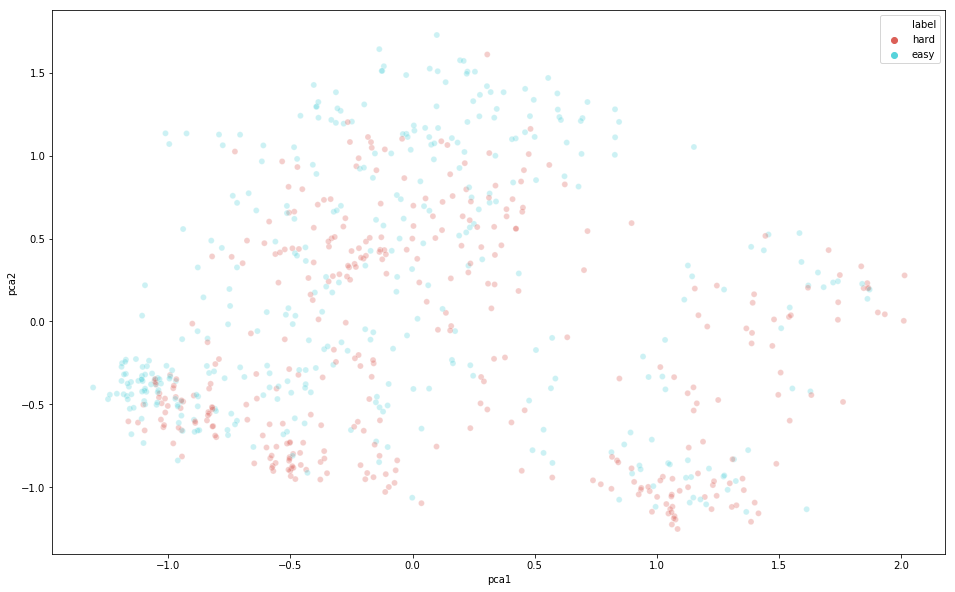

In [11]:
n_colors = 2  # len(labels)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca1", y="pca2",
    hue="label",
    palette=sns.color_palette("hls", n_colors),
    data=df.loc[rndperm,:],   # rndperm is redundant here
    legend="full",
    alpha=0.3
)

### Visualizing LOINC: t-SNE

In [12]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=15, n_iter=300)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 722 samples in 0.004s...
[t-SNE] Computed neighbors for 722 samples in 0.044s...
[t-SNE] Computed conditional probabilities for sample 722 / 722
[t-SNE] Mean sigma: 0.907508
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.433823
[t-SNE] Error after 300 iterations: 1.373346
t-SNE done! Time elapsed: 3.921841859817505 seconds


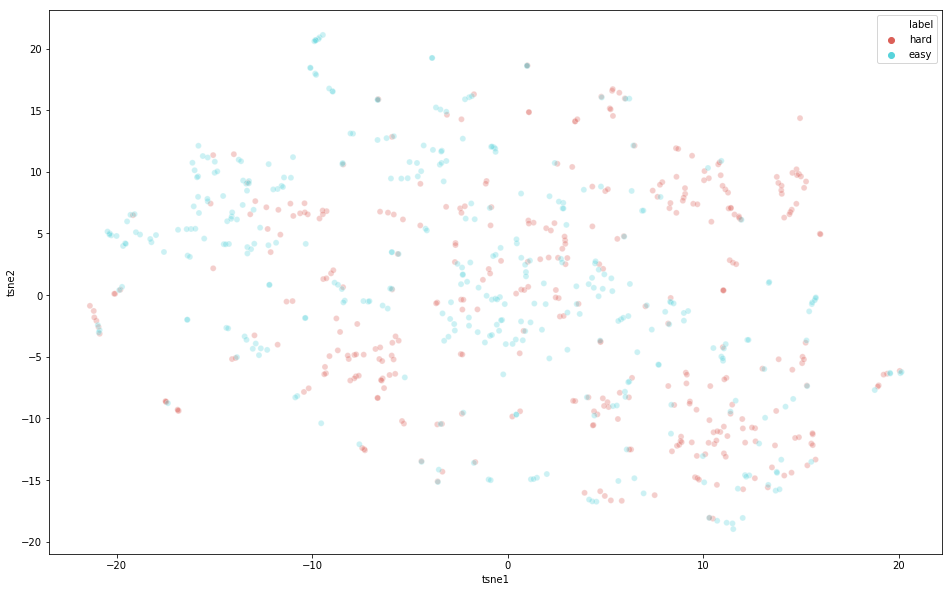

In [13]:
df['tsne1'] = tsne_results[:,0]
df['tsne2'] = tsne_results[:,1]
plt.figure(figsize=(16,10))

# note: requires seaborn-0.9.0
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="label",
    palette=sns.color_palette("hls", n_colors),
    data=df,
    legend="full",
    alpha=0.3
)


### Error Analysis Part II

In [14]:
# {easy, hard} vs medivo test result type (MTRT)
from analyzer import label_by_performance, analyze_by_values, load_data
"""
Memo
----
   df: 6-parts training data
   codes_easy = df.loc[df['label'] == 'easy'][ 'code' ].values
   codes_hard = df.loc[df['label'] == 'hard'][ 'code' ].values

"""
cohort = 'hepatitis-c'

categories = ['easy', 'hard', 'low']  # low: low sample size
ccmap = label_by_performance(cohort='hepatitis-c', categories=categories)
assert len(ccmap) == len(categories), "n(ccmap): {} <> n(cat): {}".format(len(ccmap), len(categories))

# a dictionary of LOINC table dataframes indexed by analysis categories (e.g. easy, hard)
D = analyze_by_values(ccmap, verbose=0) # 
print("> key(D): {}".format(D.keys()))

# easy cases
df0 = D['easy']
df1 = D['hard']
df2 = D['low']
# ... ['LOINC_NUM' 'LONG_COMMON_NAME' 'SHORTNAME' 'RELATEDNAMES2' 
# ...  'STATUS_TEXT' 'PROPERTY' 'TIME_ASPCT' 'SYSTEM' 'METHOD_TYP' 'SCALE_TYP' 'CLASS']

# [todo] somehow the following assertion is not always true! 
# for cat in categories: 
#     assert len(ccmap[cat]) == D[cat].shape[0], "{} <> {}".format(len(ccmap[cat]), D[cat].shape[0])

col_key = 'LOINC_NUM'
cohort = 'hepatitis-c'
print("> col(df_easy): {} | dim(df0): {}".format(df0.columns.values, df0.shape))
codes_src = load_loinc_table(dehyphenate=True)['LOINC_NUM'].values 
codes_target = load_performance(input_dir='result', cohort=cohort)['code'].values

codes_easy = df0[col_key].values
codes_hard = df1[col_key].values 
codes_low =  df2[col_key].values
codes_missed = list(set(codes_target)-set(codes_src))
print("> n(easy): {}, n(hard): {}, n(low): {}".format(len(codes_easy), len(codes_hard), len(codes_low)))
print("> n(missed): {}".format(len(codes_missed)))
      
#####################################################################
# Total number of codes: 733 | n(low_sample): 273(37.244%), n(scored):460(62.756%), n(high scored):386(52.66%)

> dim(performance matrix): (733, 4)
(label_by_performance) dim(df_perf): (733, 4)
1. Total number of codes: 733 | n(low_sample): 292(39.836%), n(scored):441(60.164%), n(high scored):371(50.614%)
2. Pecentage scored codes: 60.164%
3. Percentage "good" codes: 50.614%
> dim(table): (92369, 46)
> key(D): dict_keys(['easy', 'hard', 'low'])
> col(df_easy): ['LOINC_NUM' 'LONG_COMMON_NAME' 'SHORTNAME' 'RELATEDNAMES2' 'STATUS_TEXT'
 'COMPONENT' 'PROPERTY' 'TIME_ASPCT' 'SYSTEM' 'SCALE_TYP' 'METHOD_TYP'
 'CLASS'] | dim(df0): (368, 12)
> dim(table): (92369, 46)
> dim(performance matrix): (733, 4)
> n(easy): 368, n(hard): 68, n(low): 286
> n(missed): 11


#### Error Analysis II: EDA

In [15]:
def has_null(df, cols=['test_result_name', 'test_result_value', ]): 
    for col in cols: 
        if df[col].isnull().values.any(): 
            return True
    return False
def subset_by_null(df, cols=['test_result_name', 'test_result_value', ]): 
    tvals = np.array([True] * df.shape[1])
    for i, col in enumerate(cols): 
    
        if i == 0: 
            tvals = df[col].isnull().values
        else: 
            tvals = np.logical_or(tvals, df[col].isnull().values)
            
    if np.sum(tvals) > 0: 
        return df[tvals]
    return DataFrame()  # dummy

from loinc import make_6p

# MTRT dataframe / training data
df = load_data(cohort=cohort, verbose=1)  # the original training data with relevant MTRT attributes
N0 = df.shape[0]

# drop duplicates # e.g. df.drop_duplicates(subset=['launched', 'code'], keep='last')
df = df.drop_duplicates(keep='last')  
N = df.shape[0]
print(f"> Drop dup | n(before): {N0} >? n(after): {N}")

# ... ['test_order_code' 'test_order_name' 'test_result_code' 'test_result_name' 'test_result_value' 
# ...  'test_result_range' ... ]
print("> col(df): {}\n".format(df.columns.values))
col_key_mtrt = 'test_result_loinc_code'

col_key = 'LOINC_NUM'
n_to_process = 0
tShowAll = False
for cat in ['hard', 'low']: 
    
    print(f"> Inspecting '{cat}' codes")
    dfl = D[cat]
    codes = dfl[col_key].values
    for i, code in enumerate(codes): # foreach code found in the loinc table
        ieff = i+1
        
        # 6 parts 
        six_parts = make_6p(dfl, code)
        
        # find its corresponding patient attributes in the original training data
        dfe = df.loc[df[col_key_mtrt] == code] 
        
        # find the sample size (n_pos)
        N = df_perf[df_perf['code'] == code]['n_pos'].iloc[0]  # ['code', 'mean', 'std', 'n_pos']

        msg = ""
        if tShowAll or has_null(dfe, cols=['test_result_name', 'test_result_value', 'medivo_test_result_type']): 
            
            n0 = dfe.shape[0]
            dfe = subset_by_null(dfe, cols=['test_result_name', 'test_result_value', 'medivo_test_result_type'])
            n = dfe.shape[0]
            print("> n(matched): {} -> {}".format(n0, n))  # this is usually > 1
            
            if n > 0: 
                dfe = dfe.sample(n=min(2, n))

                msg += "[{}] {} (N={}) => \n".format(ieff, code, N)
                msg += "    + 6 parts:          {}\n".format(six_parts)
                msg += "    + test_order_code:  {}\n".format(dfe['test_order_code'].values)
                msg += "    + test_order_name:  {}\n".format(dfe['test_order_name'].values)
                # msg += "    + test_result_code: {}\n".format(dfe['test_result_code'].values)
                msg += "    + test_result_name: {}\n".format(dfe['test_result_name'].values)
                msg += "    + test_result_value: {}\n".format(dfe['test_result_value'].values)
                
                msg += "-" * 50 + '\n'
                if 'test_result_comments' in dfe.columns: 
                    msg += "    + test_result_comments: {}\n".format(dfe['test_result_comments'].values)
                msg += "    + medivo_test_result_type: {}\n".format(dfe['medivo_test_result_type'].values)
                print(msg)
                

(load_data) Loaded dataframe (dim=(142366, 21)) from:
/Users/barnett/Documents/work/loinc_predictor/data/ts-hepatitis-c.csv

> Drop dup | n(before): 142366 >? n(after): 140952
> col(df): ['age' 'patient_gender' 'patient_state' 'patient_bill_type' 'fasting'
 'test_result_status' 'test_order_code' 'test_order_name'
 'test_result_code' 'test_result_name' 'test_result_value'
 'test_result_range' 'test_result_abnormal_flag'
 'test_result_reference_range' 'test_result_units_of_measure'
 'test_result_comments' 'test_cpt_code' 'panel_order_code'
 'panel_order_name' 'medivo_test_result_type' 'test_result_loinc_code']

> Inspecting 'hard' codes
> n(matched): 10 -> 2
[10] 149591 (N=10) => 
    + 6 parts:          Albumin/Creatinine|MRto|Pt|Urine|Qn|Detection limit <= 20 mg/L
    + test_order_code:  ['1657' '661']
    + test_order_name:  ['MICROALBUMIN - RANDOM URINE' 'MICROALBUMIN,RANDOM URINE w/CREAT']
    + test_result_name: ['MICROALB/CREAT RATIO' 'MICROALBUMIN/CREATININE,RANDOM']
    + test_r

> n(matched): 1 -> 1
[5] 109926 (N=1) => 
    + 6 parts:          Norclozapine|MCnc|Pt|Ser/Plas|Qn|nan
    + test_order_code:  ['5825']
    + test_order_name:  ['CLOZAPINE']
    + test_result_name: ['NORCLOZAPINE']
    + test_result_value: ['98']
--------------------------------------------------
    + test_result_comments: [nan]
    + medivo_test_result_type: [nan]

> n(matched): 2 -> 2
[7] 110130 (N=2) => 
    + 6 parts:          DNA double strand Ab|Titr|Pt|Ser|Qn|nan
    + test_order_code:  ['ANAFUL' 'ANAFUL']
    + test_order_name:  ['ANA Full Panel' 'ANA Full Panel']
    + test_result_name: ['ADNA with IFA Titer' 'ADNA with IFA Titer']
    + test_result_value: ['<10' '<10']
--------------------------------------------------
    + test_result_comments: ['Result is expressed as the reciprocal of the titer.'
 'Result is expressed as the reciprocal of the titer.']
    + medivo_test_result_type: [nan nan]

> n(matched): 2 -> 2
[11] 112532 (N=2) => 
    + 6 parts:          Tacrolimus|M

> n(matched): 1 -> 1
[87] 223123 (N=1) => 
    + 6 parts:          Hepatitis A virus Ab|ACnc|Pt|Ser|Qn|nan
    + test_order_code:  ['F153']
    + test_order_name:  ['HEPATITIS A AB TOTAL']
    + test_result_name: ['Hepatitis A Ab Total']
    + test_result_value: ['Negative']
--------------------------------------------------
    + test_result_comments: [nan]
    + medivo_test_result_type: [nan]

> n(matched): 1 -> 1
[90] 225805 (N=1) => 
    + 6 parts:          Toxoplasma gondii Ab.IgG|PrThr|Pt|Ser|Ord|nan
    + test_order_code:  ['4659']
    + test_order_name:  ['TOXOPLASMA IgG ANTIBODY']
    + test_result_name: ['TOXOPLASMA IgG ANTIBODY']
    + test_result_value: ['NON-REACT']
--------------------------------------------------
    + test_result_comments: ['INTERPRETATION TOXOPLASMA IgG  NON-REACTIVE IU/ML <=6.5  INDETERMINATE IU/ML 6.6-7.9  REACTIVE IU/ML >=8.0  NOTE: Non-reactive specimens are those that fall in a result  range of <=6.5 IU/ML. Product insert does not allow  numerica

> n(matched): 1 -> 1
[148] 356188 (N=1) => 
    + 6 parts:          Methadone|MCnc|Pt|Ser/Plas|Qn|Screen
    + test_order_code:  ['4449']
    + test_order_name:  ['DRUGS OF ABUSE-11,WITH CONFIRMATION']
    + test_result_name: ['METHADONE']
    + test_result_value: ['See Note']
--------------------------------------------------
    + test_result_comments: ['Confirmation to follow.']
    + medivo_test_result_type: [nan]

> n(matched): 3 -> 3
[150] 37192 (N=3) => 
    + 6 parts:          Lithium|MCnc|Pt|Ser/Plas|Qn|nan
    + test_order_code:  ['2128' '2128']
    + test_order_name:  ['LITHIUM' 'LITHIUM']
    + test_result_name: ['LITHIUM' 'LITHIUM']
    + test_result_value: ['0.23' '<0.05']
--------------------------------------------------
    + test_result_comments: [nan nan]
    + medivo_test_result_type: [nan nan]

> n(matched): 1 -> 1
[152] 390179 (N=1) => 
    + 6 parts:          Mycobacterium tuberculosis tuberculin stimulated gamma interferon/Mitogen stimulated gamma interferon|Rel

> n(matched): 1 -> 1
[230] 62992 (N=1) => 
    + 6 parts:          Urea nitrogen|MCnc|Pt|Bld|Qn|nan
    + test_order_code:  ['W2005S']
    + test_order_name:  ['CMP']
    + test_result_name: ['BUN (Blood Urea Nitrogen)']
    + test_result_value: ['13']
--------------------------------------------------
    + test_result_comments: [nan]
    + medivo_test_result_type: [nan]

> n(matched): 1 -> 1
[232] 63313 (N=1) => 
    + 6 parts:          Campylobacter sp identified|Prid|Pt|Stool|Nom|Organism specific culture
    + test_order_code:  ['206025']
    + test_order_name:  ['Culture,Campylobacter']
    + test_result_name: ['CULTURE,CAMPYLOBACTER']
    + test_result_value: [nan]
--------------------------------------------------
    + test_result_comments: ['No enteric Campylobacter isolated.']
    + medivo_test_result_type: ['Campylobacter sp identified in Stool by Organism specific culture']

> n(matched): 1 -> 1
[233] 634642 (N=1) => 
    + 6 parts:          Treponema pallidum Ab|ACnc|Pt|S

> n(matched): 2 -> 2
[270] 823765 (N=2) => 
    + 6 parts:          Elbasvir|Susc|Pt|Isolate|Ord|Genotyping
    + test_order_code:  ['65329' '92447']
    + test_order_name:  ['HCV RNA Genotpe 1 NS5a Drug Re' 'HEPATITIS C VIRAL RNA GENOTYPE 1 NS']
    + test_result_name: ['Elbasvir Resistance' 'ELBASVIR RESISTANCE']
    + test_result_value: ['NOT PREDICTED' 'PROBABLE']
--------------------------------------------------
    + test_result_comments: [nan nan]
    + medivo_test_result_type: [nan nan]

> n(matched): 2 -> 2
[271] 823807 (N=2) => 
    + 6 parts:          Hepatitis C virus genotype 1 NS5a gene mutations detected|Prid|Pt|Isolate|Nom|Genotyping
    + test_order_code:  ['92447' '8700092447']
    + test_order_name:  ['HEPATITIS C VIRAL RNA GENOTYPE 1 NS'
 'HEPATITIS C VIRAL RNA GENO 1 NS5a DRUG RESIST']
    + test_result_name: ['HCV NS5A SUBTYPE' 'HCV NS5a SUBTYPE']
    + test_result_value: ['1a' '1a']
--------------------------------------------------
    + test_result_comments: [

#### Error Analysis: Rule-based Predictor